# NOTEBOOK 02: HYBRID TRANSIT ROUTING SIMULATION
**Objective:** To design an intelligent, multi-modal transit network (Heavy Rail + BRT) that mathematically connects Nairobi's distinct socio-economic residential zones to their appropriate economic hubs.

## PHASE 1: DATA INGESTION
We begin by loading the classified `Origins` (the workforce) and `Destinations` (the jobs) generated in Notebook 01. 

## PHASE 2: THE HEAVY RAIL BACKBONE (INTER-HUB TRANSIT)
Train tracks are expensive and should not be placed randomly. We will use the **Minimum Spanning Tree (MST)** algorithm to build a high-speed rail backbone. This network will strictly connect the Major Job Hubs together, ensuring fluid movement between the Corporate nodes (CBD, Upper Hill) and the Industrial/Soko nodes (Embakasi, Gikomba).

In [1]:
# ==========================================
# PHASE 1: ENVIRONMENT & DATA INGESTION
# ==========================================
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import os
import warnings
warnings.filterwarnings('ignore')

print("[INFO] Initializing Notebook 02: Hybrid Transit Routing...")

# Paths to your Notebook 01 exports (Using your absolute paths)
DEST_PATH = r"C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed\classified_destinations.csv"
ORIG_PATH = r"C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed\classified_origins.csv"

# Load the Data
df_dest = pd.read_csv(DEST_PATH)
df_orig = pd.read_csv(ORIG_PATH)

# Convert back to GeoDataFrames (using the projected UTM 37S coordinates from Notebook 1)
gdf_dest = gpd.GeoDataFrame(df_dest, geometry=gpd.points_from_xy(df_dest.x, df_dest.y), crs="EPSG:32737")
gdf_orig = gpd.GeoDataFrame(df_orig, geometry=gpd.points_from_xy(df_orig.x, df_orig.y), crs="EPSG:32737")

print(f"[SUCCESS] Loaded {len(gdf_dest)} Job Hubs and {len(gdf_orig)} Workforce Nodes.")

# ==========================================
# PHASE 2: THE HEAVY RAIL BACKBONE (MST)
# ==========================================
print("\n[INFO] Calculating the Heavy Rail Inter-Hub Network (MST)...")

# Create a fully connected graph of all the Job Hubs
G_rail = nx.Graph()

# Add hubs as nodes
for i, row in gdf_dest.iterrows():
    G_rail.add_node(row['hub_id'], pos=(row.geometry.x, row.geometry.y), type=row['type'], name=row['name'])

# Calculate the straight-line distance between every single hub
for i, row1 in gdf_dest.iterrows():
    for j, row2 in gdf_dest.iterrows():
        if i < j:
            dist = row1.geometry.distance(row2.geometry)
            G_rail.add_edge(row1['hub_id'], row2['hub_id'], weight=dist)

# Use Minimum Spanning Tree to find the absolute most efficient rail network 
# that connects all hubs without redundant loops
mst_rail = nx.minimum_spanning_tree(G_rail)

# Extract the Rail Lines as geometries so we can map them later
rail_lines = []
for u, v in mst_rail.edges():
    pt1 = Point(mst_rail.nodes[u]['pos'])
    pt2 = Point(mst_rail.nodes[v]['pos'])
    rail_lines.append(LineString([pt1, pt2]))

gdf_rail = gpd.GeoDataFrame(geometry=rail_lines, crs="EPSG:32737")
print(f"[SUCCESS] Heavy Rail Backbone established with {len(rail_lines)} optimal track segments.")

[INFO] Initializing Notebook 02: Hybrid Transit Routing...
[SUCCESS] Loaded 21 Job Hubs and 23475 Workforce Nodes.

[INFO] Calculating the Heavy Rail Inter-Hub Network (MST)...
[SUCCESS] Heavy Rail Backbone established with 20 optimal track segments.


## PHASE 3: THE SMART COMMUTE (BRT ROUTING)
Here we execute the core socio-economic logic of the simulation.

1. **Spatial Aggregation:** We compress the 23,000 individual workforce dots into ~52 highly accurate Neighborhood Centroids to allow for rapid street-level routing.
2. **The Street Grid:** We download the physical drive network of Nairobi using `osmnx`.
3. **The Routing Logic:** We run shortest-path algorithms along the physical streets using our strict tier rules:
   * **Tier 1 (High-Income):** Routed only to Corporate Hubs.
   * **Tier 2 (Informal/Blue-Collar):** Routed only to Industrial & Soko Hubs.
   * **Tier 3 (Middle-Income):** Routed to *both* to reflect their dual role in the economy.

In [3]:
# ==========================================
# PHASE 3.1: NEIGHBORHOOD AGGREGATION
# ==========================================
print("\n[INFO] Aggregating workforce dots into Neighborhood Centroids...")

# Group by neighborhood and tier, calculate the average X and Y to find the center, and sum the population
df_neighborhoods = df_orig.groupby(['neighborhood', 'tier']).agg({
    'x': 'mean', 
    'y': 'mean', 
    'population': 'sum'
}).reset_index()

gdf_neighborhoods = gpd.GeoDataFrame(
    df_neighborhoods, 
    geometry=gpd.points_from_xy(df_neighborhoods.x, df_neighborhoods.y), 
    crs="EPSG:32737"
)
print(f"[SUCCESS] Aggregated {len(df_orig)} dots into {len(gdf_neighborhoods)} Neighborhood Stations.")

# ==========================================
# PHASE 3.2: DOWNLOADING NAIROBI STREET NETWORK
# ==========================================
print("\n[INFO] Downloading actual Nairobi road network (This may take 1-3 minutes)...")
# We download the graph in EPSG:4326 (Lat/Lon) and then project it to UTM to match our data
G_streets_latlon = ox.graph_from_place("Nairobi, Kenya", network_type="drive")
G_streets = ox.project_graph(G_streets_latlon, to_crs="EPSG:32737")
print("[SUCCESS] Physical street grid downloaded.")

# ==========================================
# PHASE 3.3: THE SMART COMMUTE ALGORITHM
# ==========================================
print("\n[INFO] Calculating Socio-Economic BRT Routes along physical streets...")

brt_routes = []

# Helper function to find the absolute closest Hub of a specific type
def get_nearest_hub(origin_geom, hub_type):
    target_hubs = gdf_dest[gdf_dest['type'] == hub_type]
    distances = target_hubs.geometry.distance(origin_geom)
    nearest_idx = distances.idxmin()
    return target_hubs.loc[nearest_idx]

for i, origin in gdf_neighborhoods.iterrows():
    orig_geom = origin.geometry
    tier = origin['tier']
    
    # 1. Determine which hubs this neighborhood is allowed to connect to
    targets = []
    if tier == "Tier_1_WhiteCollar":
        targets.append(get_nearest_hub(orig_geom, "Corporate"))
    elif tier == "Tier_2_Informal":
        targets.append(get_nearest_hub(orig_geom, "Industrial_Soko"))
    elif tier == "Tier_3_MiddleIncome":
        targets.append(get_nearest_hub(orig_geom, "Corporate"))
        targets.append(get_nearest_hub(orig_geom, "Industrial_Soko"))

    # 2. Draw the physical routes
    for target in targets:
        dest_geom = target.geometry
        
        # Snap our exact coordinates to the nearest physical street intersections
        orig_node = ox.distance.nearest_nodes(G_streets, orig_geom.x, orig_geom.y)
        dest_node = ox.distance.nearest_nodes(G_streets, dest_geom.x, dest_geom.y)
        
        try:
            # Run Dijkstra's Algorithm to find the shortest physical driving route
            route = nx.shortest_path(G_streets, orig_node, dest_node, weight='length')
            
            # --- THE FIX ---
            # If the route only has 1 node, the origin and destination are physically on the same street corner.
            if len(route) < 2:
                print(f"  [SKIPPED] Local walk: {origin['neighborhood']} to {target['name']} is zero distance.")
                continue
            # ---------------
            
            # Convert the list of node IDs into a physical geometric line
            route_coords = [(G_streets.nodes[node]['x'], G_streets.nodes[node]['y']) for node in route]
            route_line = LineString(route_coords)
            
            brt_routes.append({
                'neighborhood': origin['neighborhood'],
                'tier': tier,
                'target_hub': target['name'],
                'hub_type': target['type'],
                'population_weight': origin['population'],
                'geometry': route_line
            })
        except nx.NetworkXNoPath:
            print(f"  [WARNING] No physical road connects {origin['neighborhood']} to {target['name']}.")

gdf_brt = gpd.GeoDataFrame(brt_routes, crs="EPSG:32737")
print(f"\n[SUCCESS] Calculated {len(gdf_brt)} physical BRT routes based on Socio-Economic Tiers.")


[INFO] Aggregating workforce dots into Neighborhood Centroids...
[SUCCESS] Aggregated 23475 dots into 52 Neighborhood Stations.

[INFO] Downloading actual Nairobi road network (This may take 1-3 minutes)...
[SUCCESS] Physical street grid downloaded.

[INFO] Calculating Socio-Economic BRT Routes along physical streets...
  [SKIPPED] Local walk: Kilimani to Kilimani is zero distance.
  [SKIPPED] Local walk: Riverside to Riverside is zero distance.

[SUCCESS] Calculated 70 physical BRT routes based on Socio-Economic Tiers.


## PHASE 4: VISUALIZATION & MASTER EXPORT
We now render the complete simulation. 
* **Black Lines:** The Heavy Rail Backbone.
* **Blue Lines:** Tier 1 (High-Income) BRT Commutes.
* **Red Lines:** Tier 2 (Informal) BRT Commutes.
* **Purple Lines:** Tier 3 (Middle-Income) BRT Commutes.
* **Stars:** The Economic Destinations.


[INFO] Rendering Master Transit Map...


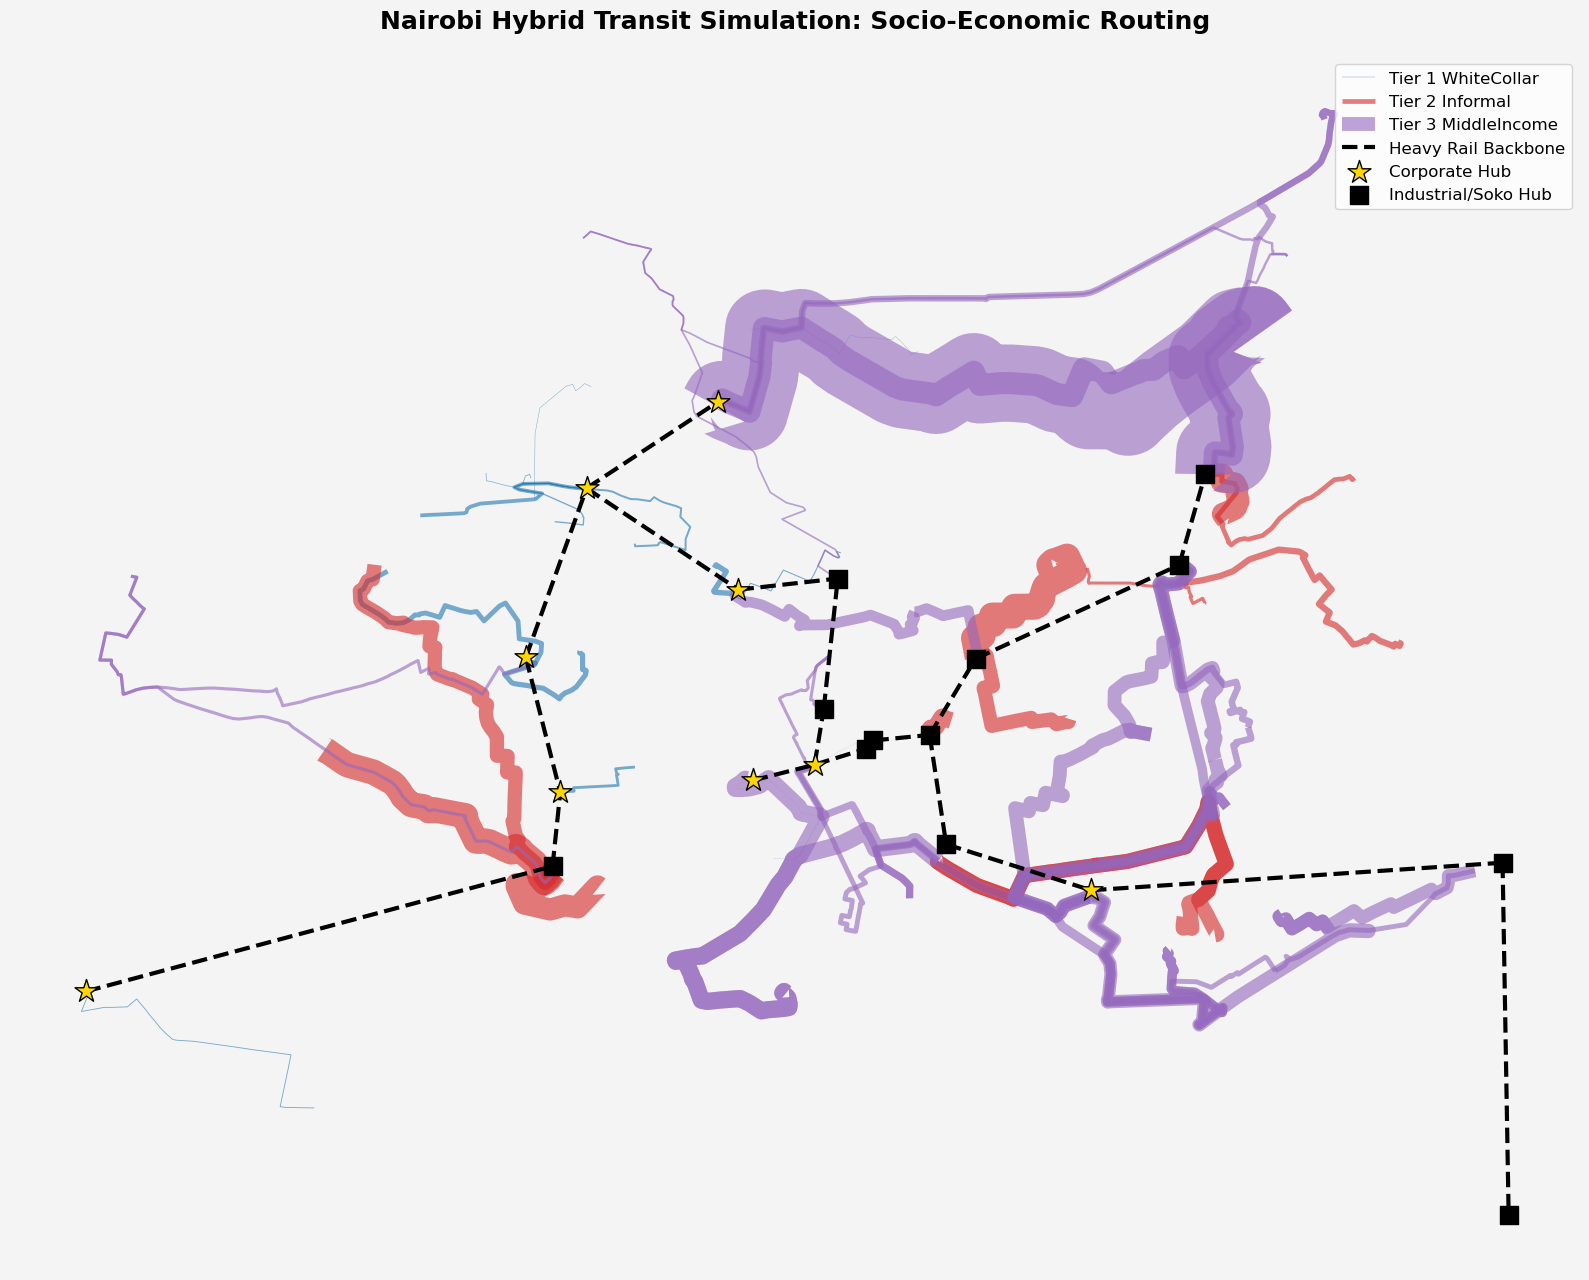

[COMPLETE] Master Map saved to: C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed\Nairobi_Master_Transit_Map.png
--- SIMULATION FINISHED ---


In [4]:
# ==========================================
# PHASE 4: VISUALIZATION & EXPORT
# ==========================================
print("\n[INFO] Rendering Master Transit Map...")

fig, ax = plt.subplots(figsize=(16, 16), facecolor="#f4f4f4")
ax.set_facecolor('#f4f4f4')
ax.set_title("Nairobi Hybrid Transit Simulation: Socio-Economic Routing", fontsize=18, fontweight='bold', pad=20)

# 1. Plot the BRT Routes based on Tier
color_map = {
    'Tier_1_WhiteCollar': '#1f77b4', # Blue
    'Tier_2_Informal': '#d62728',    # Red
    'Tier_3_MiddleIncome': '#9467bd' # Purple
}

for tier, color in color_map.items():
    subset = gdf_brt[gdf_brt['tier'] == tier]
    # Line thickness is weighted by population
    subset.plot(ax=ax, color=color, linewidth=subset['population_weight']/15000, alpha=0.6, label=tier.replace("_", " "))

# 2. Plot the Heavy Rail Backbone
gdf_rail.plot(ax=ax, color='black', linewidth=3, linestyle='--', zorder=5, label='Heavy Rail Backbone')

# 3. Plot the Destinations (Job Hubs)
corp_hubs = gdf_dest[gdf_dest['type'] == 'Corporate']
ind_hubs = gdf_dest[gdf_dest['type'] == 'Industrial_Soko']

corp_hubs.plot(ax=ax, marker='*', color='gold', markersize=300, edgecolor='black', zorder=6, label='Corporate Hub')
ind_hubs.plot(ax=ax, marker='s', color='black', markersize=150, zorder=6, label='Industrial/Soko Hub')

# Formatting the map
ax.set_axis_off()
plt.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white')
plt.tight_layout()

# Save the Map
output_img = r"C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed\Nairobi_Master_Transit_Map.png"
plt.savefig(output_img, dpi=300, bbox_inches='tight')
plt.show()

print(f"[COMPLETE] Master Map saved to: {output_img}")
print("--- SIMULATION FINISHED ---")

In [6]:
# ==========================================
# DIAGNOSTIC VERIFICATION REPORT
# ==========================================
import networkx as nx

print("======================================================")
print("      NAIROBI HYBRID TRANSIT: VERIFICATION REPORT")
print("======================================================\n")

print("--- 1. HEAVY RAIL BACKBONE (INTER-HUB CONNECTIONS) ---")
# Iterate through the Minimum Spanning Tree to see the exact train tracks
for u, v, data in mst_rail.edges(data=True):
    hub_u = G_rail.nodes[u]['name']
    hub_v = G_rail.nodes[v]['name']
    dist_km = data['weight'] / 1000 # Convert meters to kilometers
    print(f"🚆 [RAIL] {hub_u: <25} <--->  {hub_v: <25} ({dist_km:.2f} km)")

print("\n--- 2. SMART COMMUTE ROUTES (BRT CONNECTIONS) ---")
# Iterate through the BRT routes, grouped by Tier for easy reading
tiers_to_check = ['Tier_1_WhiteCollar', 'Tier_2_Informal', 'Tier_3_MiddleIncome']

for tier in tiers_to_check:
    print(f"\n>> {tier.replace('_', ' ').upper()} <<")
    subset = gdf_brt[gdf_brt['tier'] == tier].sort_values(by='neighborhood')
    
    if subset.empty:
        print("  (No routes calculated for this tier)")
        continue
        
    for _, row in subset.iterrows():
        origin = row['neighborhood']
        dest = row['target_hub']
        pop = row['population_weight']
        
        # Calculate physical street route length
        route_length_km = row['geometry'].length / 1000
        
        print(f"🚌 [BRT] {origin: <20} --->  {dest: <25} (Pop: {pop:,.0f} | Route: {route_length_km:.1f} km)")
        
print("\n======================================================")
print("                VERIFICATION COMPLETE")
print("======================================================")

      NAIROBI HYBRID TRANSIT: VERIFICATION REPORT

--- 1. HEAVY RAIL BACKBONE (INTER-HUB CONNECTIONS) ---
🚆 [RAIL] Nairobi Central           <--->  Muthurwa                  (0.97 km)
🚆 [RAIL] Nairobi Central           <--->  Nyamakima                 (1.02 km)
🚆 [RAIL] Nairobi Central           <--->  Upper Hill                (1.15 km)
🚆 [RAIL] Westlands                 <--->  Gigiri                    (2.83 km)
🚆 [RAIL] Westlands                 <--->  Lavington                 (3.24 km)
🚆 [RAIL] Westlands                 <--->  Parklands                 (3.29 km)
🚆 [RAIL] Kilimani                  <--->  Toi Market                (1.34 km)
🚆 [RAIL] Kilimani                  <--->  Lavington                 (2.51 km)
🚆 [RAIL] Riverside                 <--->  Industrial Area           (2.74 km)
🚆 [RAIL] Riverside                 <--->  Embakasi                  (7.43 km)
🚆 [RAIL] Parklands                 <--->  City Park Market          (1.80 km)
🚆 [RAIL] Karen                     <

## PHASE 5: MASTER DATA EXPORT (GEOJSON & CSV)
To preserve the routing calculations, we export the final geometric layers. 
1. **GeoJSON:** The global standard for interactive web mapping (perfect for Kepler.gl, Felt, or Streamlit).
2. **CSV (with WKT):** The standard tabular format. We convert the physical map shapes into **Well-Known Text (WKT)** so they can be easily loaded into Power BI, Tableau, or future Python scripts.

In [8]:
# ==========================================
# PHASE 5: MASTER EXPORT (GEOJSON & CSV)
# ==========================================
import os
import warnings
import pandas as pd

print("[INFO] Projecting Geometries to GPS Standard (WGS84)...")

# Convert the UTM metric geometries back to standard Latitude/Longitude
gdf_rail_export = gdf_rail.to_crs("EPSG:4326")
gdf_brt_export = gdf_brt.to_crs("EPSG:4326")
gdf_neighborhoods_export = gdf_neighborhoods.to_crs("EPSG:4326")

output_dir = r"C:\Users\Administrator\Desktop\Nairobi_Transit_Optimizer\data\processed"
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------
# 1. EXPORT TO GEOJSON (For Web Mapping)
# ------------------------------------------
print("[INFO] Exporting to GeoJSON format...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gdf_rail_export.to_file(os.path.join(output_dir, "nairobi_heavy_rail.geojson"), driver="GeoJSON")
    gdf_brt_export.to_file(os.path.join(output_dir, "nairobi_brt_routes.geojson"), driver="GeoJSON")
    gdf_neighborhoods_export.to_file(os.path.join(output_dir, "nairobi_hubs.geojson"), driver="GeoJSON")

# ------------------------------------------
# 2. EXPORT TO CSV (For Power BI / Data Analysis)
# ------------------------------------------
print("[INFO] Converting Geometries to WKT and Exporting to CSV...")

# We convert the spatial map shapes into readable text (WKT) for the CSV
df_rail_csv = pd.DataFrame(gdf_rail_export.assign(geometry=gdf_rail_export.geometry.apply(lambda x: x.wkt)))
df_brt_csv = pd.DataFrame(gdf_brt_export.assign(geometry=gdf_brt_export.geometry.apply(lambda x: x.wkt)))
df_neighborhoods_csv = pd.DataFrame(gdf_neighborhoods_export.assign(geometry=gdf_neighborhoods_export.geometry.apply(lambda x: x.wkt)))

df_rail_csv.to_csv(os.path.join(output_dir, "nairobi_heavy_rail.csv"), index=False)
df_brt_csv.to_csv(os.path.join(output_dir, "nairobi_brt_routes.csv"), index=False)
df_neighborhoods_csv.to_csv(os.path.join(output_dir, "nairobi_hubs.csv"), index=False)

print("\n [SUCCESS] All datasets flawlessly exported in both GeoJSON and CSV formats!")

[INFO] Projecting Geometries to GPS Standard (WGS84)...
[INFO] Exporting to GeoJSON format...
[INFO] Converting Geometries to WKT and Exporting to CSV...

 [SUCCESS] All datasets flawlessly exported in both GeoJSON and CSV formats!
